<a href="https://colab.research.google.com/github/JackyOOOO/FX-Deep-learning/blob/main/FX_Algo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Functions and Libraries

In [ ]:
!pip install ta
!pip install keras

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29413 sha256=1431cfbb0ade1cdb7ff33b63f6c348fcbe3b6a792144f40955b1158457547900
  Stored in directory: /root/.cache/pip/wheels/5f/67/4f/8a9f252836e053e532c6587a3230bc72a4deb16b03a829610b
Successfully built ta


In [ ]:
import pandas as pd
import numpy as np
from ta import add_all_ta_features
from ta.utils import dropna
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
# from keras.utils import np_utils
# from keras.utils.np_utils import to_categorical
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense, Activation,  MaxPooling1D
from keras.layers import Reshape
from keras.layers import Conv1D
from keras.layers import LeakyReLU
from keras.layers import BatchNormalization
from keras.layers import Flatten
from sklearn.metrics import confusion_matrix
from keras import optimizers
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler # In case loss = NaN

import yfinance as yf
import datetime as dt

In [ ]:
def label(open_price, m = 6, p = 0.0065) :
    #Label y
    y = open_price
    y_list=[]
    for i in range(len(y)-m):
        y_value=np.array([y[i:i+m]])
        y_list.append(y_value)

    label=[]
    for b in range(len(y_list)):
        for j in range(m):
            value=[]
            value.append(np.log(y_list[b].reshape(m,1)[j]) - np.log(y_list[b].reshape(m,1)[0]))

        down_loc=np.where(np.array(value)< -p )[0]
        if (len(down_loc) >= 1):
            down_loc = down_loc.reshape(len(down_loc),1)[0]

        up_loc=np.where(np.array(value) > p)[0]
        if (len(up_loc) >= 1):
            up_loc = up_loc.reshape(len(up_loc),1)[0]

        if (len(down_loc) >= 1) & (len(up_loc) == 0):
            label.append(-1)

        if (len(down_loc) == 0) & (len(up_loc) >= 1):
            label.append(1)

        if (len(down_loc) >= 1) & (len(up_loc) >= 1):
            if down_loc[0]>up_loc[0]:
                label.append(1)
            if down_loc[0]<up_loc[0]:
                label.append(-1)

        if (len(up_loc) ==0) & (len(down_loc) ==0):
            label.append(0)

    Y = label
    return(label)

def encode(label):
    '''One hot labeling
    args:
        label: [list] 1D label array. -1: sell, 1: buy, 0: no action

    return:
        [list] one hot label. 0: sell, 1: buy, 2: no action( -1 -> [1, 0, 0], 1 -> [0, 1, 0], 0 -> [0, 0, 1])
    '''
    out = np.zeros((len(label), 3))

    for pos, i in enumerate(label):
        if i == 1:
            out[pos, 1] = 1
        elif i == -1:
            out[pos, 0] = 1
        else:
            out[pos, 2] = 1
    return out

def create_cnn_up(d):

    #  Create the convolutional base  #
    tf.random.set_seed(0)
    model = Sequential()
    # model.add(Reshape((-1,4), input_shape=(d,)))
    # model.add(Conv1D(128, 2, padding='valid', kernel_initializer='he_uniform'))

    model.add(Conv1D(128, 2, padding='valid', kernel_initializer='he_uniform', input_shape=(d,1)))
    model.add(Dense(128,activation='softmax', dtype='float32'))
    model.add(MaxPooling1D(4))
    model.add(layers.Dropout(0.25))
    model.add(Conv1D(32, 2, padding='valid', kernel_initializer='he_uniform'))
    model.add(layers.BatchNormalization())
    model.add(Conv1D(32, 2, padding='valid', kernel_initializer='he_uniform'))
    model.add(layers.BatchNormalization())
    model.add(Conv1D(16, 2, padding='valid', kernel_initializer='he_uniform'))
    model.add(Conv1D(16, 1, padding='valid', kernel_initializer='he_uniform'))

    model.add(layers.Dropout(0.75))
    model.add(LeakyReLU(alpha=0.01))

    model.add(Flatten())
    model.add(Dense(3,activation='softmax', dtype='float32'))
    opt = tf.keras.optimizers.SGD(learning_rate= 0.01, momentum=0.9, clipnorm = 5)

    #          Compile model          #

    model.compile(optimizer = opt, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

def create_cnn_down(d):

    #  Create the convolutional base  #
    tf.random.set_seed(0)
    model = Sequential()
    # model.add(Reshape((-1,4), input_shape=(d,)))
    # model.add(Conv1D(128, 2, padding='valid', kernel_initializer='he_uniform'))

    model.add(Conv1D(128, 2, padding='valid', kernel_initializer='he_uniform', input_shape=(d,1)))
    model.add(Dense(128,activation='softmax', dtype='float32'))
    model.add(MaxPooling1D(4))
    model.add(layers.Dropout(0.5))
    model.add(Conv1D(32, 2, padding='valid', kernel_initializer='he_uniform'))
    model.add(layers.BatchNormalization())
    model.add(Conv1D(32, 2, padding='valid', kernel_initializer='he_uniform'))
    model.add(layers.BatchNormalization())
    model.add(Conv1D(32, 2, padding='valid', kernel_initializer='he_uniform'))
    model.add(Conv1D(16, 1, padding='valid', kernel_initializer='he_uniform'))

    model.add(layers.Dropout(0.5))
    model.add(LeakyReLU(alpha=0.01))

    model.add(Flatten())
    model.add(Dense(3,activation='softmax', dtype='float32'))
    opt = tf.keras.optimizers.SGD(learning_rate= 0.01, momentum=0.9, clipnorm = 5)

    #          Compile model          #

    model.compile(optimizer = opt, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

def fine_tune(model, last_update, end_date=dt.datetime.today(), stock ="EURUSD=X", m = 6):
    data = yf.download(stock, end = end_date)

    last_update_loc = np.where(np.array([str(i).split(' ')[0] for i in data.index])==last_update)[0][0]

    if [True if len(data.iloc[last_update_loc+1:,:])>m else False][0]:
        ta_df = add_all_ta_features(data.astype(float), open="Open", high="High", low="Low",
                                                              close="Close", volume="Volume", fillna = True)
        ta_df = ta_df.drop( 'Adj Close', axis = 1)
        y = label(open_price = ta_df.Close.astype(float), m = m, p = 0.0065)

        y_cnn = encode(y)[last_update_loc+1:]
        print(last_update_loc)
        trainX = ta_df[:-6].copy()
        # testX  = ta_df[-1:].copy()

        d =  trainX.shape[1]
        mean = trainX.mean()
        sd = trainX.std()
        trainX = ( trainX -mean ) / sd

        trainX = trainX.fillna(0) #additional
        trainX = trainX[last_update_loc+1:]
        cp_callback = tf.keras.callbacks.EarlyStopping(monitor ='loss', patience = 20)
        print('Training Started')
        model.fit(trainX, y_cnn, epochs=1000, verbose= 0 ,callbacks=[cp_callback])
        print('Training Finished')
        print(y_cnn)
        print(trainX)
        print('latest update '+ str(ta_df[last_update_loc+1:-6].index[-1]).split(' ')[0])

    else:
      print('This is the latest model')





### Market Data & Model Selection


In [ ]:
# start_date = dt.datetime.today()- dt.timedelta(1256)
end_date = dt.datetime.today()
stock ="EURUSD=X"
# data = yf.download(stock, start_date)
data = yf.download(stock)

ta_df = add_all_ta_features(data.astype(float), open="Open", high="High", low="Low",
                                                            close="Close", volume="Volume", fillna = True)
ta_df = ta_df.drop( 'Adj Close', axis = 1)

str(ta_df.index[-1])

[*********************100%%**********************]  1 of 1 completed


'2023-12-14 00:00:00'

In [ ]:
y = label(open_price = ta_df.Close.astype(float), m = 6, p = 0.0015)

y_cnn = encode(y)
trainX = ta_df[:-6].copy()
testX  = ta_df[-1:].copy()

d =  trainX.shape[1]
mean = trainX.mean()
sd = trainX.std()
trainX = ( trainX -mean ) / sd

trainX = trainX.fillna(0) #additional

In [ ]:
time = str(ta_df[-1:].index[0]).split('-')[0]
# up = ['2013', '2017', '2020']
vol_yr_mean = ta_df.Close.pct_change(50).rolling(50).std().groupby(by = ta_df.index.year).mean()

if vol_yr_mean.loc[int(time)-1] > 0.0175:
    up = True
    print('up', time)
elif vol_yr_mean.loc[int(time)-1] < 0.01:
    up = True
    print('up', time)
else:
    up = False
    print('down', time)

down 2023


###Training New Model

In [ ]:
# CNN Model
model_up = create_cnn_up(d)
model_down = create_cnn_down(d)
cp_callback = tf.keras.callbacks.EarlyStopping(monitor ='loss', patience = 20)
# evt.consoleLog('n_trade_day :', n_trade_day)
# evt.consoleLog('n_train :', self.n_train)

# if ((n_trade_day// 125) != n_train) :
#     n_train = n_trade_day// 125

# if ( time in up):
if up:
    # self.evt.consoleLog('u :', time)
    # self.evt.consoleLog('training cnn_model_u')
    history_up = model_up.fit(trainX, y_cnn, epochs=1000, verbose= 0 ,callbacks=[cp_callback])

else:
    # self.evt.consoleLog('d :', time)
    # self.evt.consoleLog('training cnn_model_d')
    history_down = model_down.fit(trainX, y_cnn, epochs=1000, verbose= 0 ,callbacks=[cp_callback])

[2309, 547, 2338]


(array([2309.,    0.,    0.,    0.,    0.,  547.,    0.,    0.,    0.,
        2338.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <BarContainer object of 10 artists>)

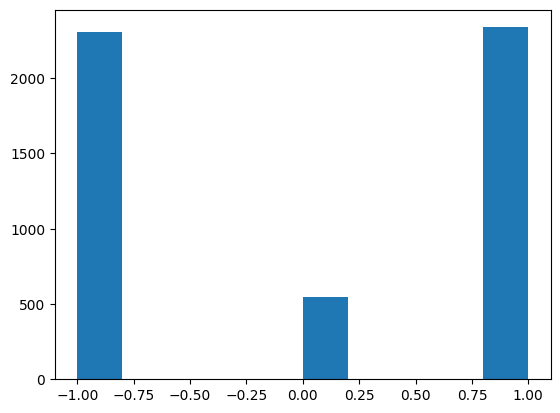

In [ ]:
import matplotlib.pyplot as plt
print([y.count(i) for i in range(-1,2)])
plt.hist(y)

[2309, 2338, 547]


(array([2309.,    0.,    0.,    0.,    0., 2338.,    0.,    0.,    0.,
         547.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

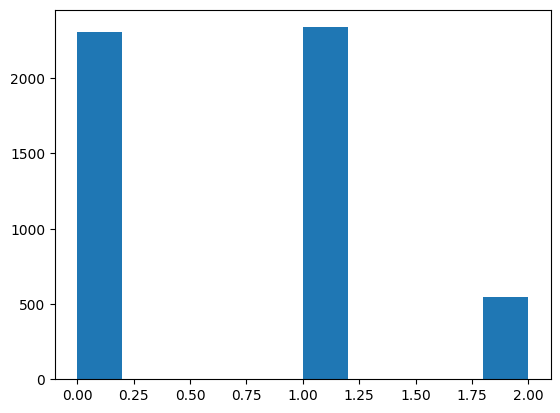

In [ ]:
train_dist = [np.where(i==1)[0][0] for i in y_cnn]
print([train_dist.count(i) for i in range(0,3)])


plt.hist(train_dist)

In [ ]:
# CNN Model prediction
# y_pred_up =  model_up.predict(testX).argmax(axis=1)[0]
# y_pred_down =  model_down.predict(testX).argmax(axis=1)[0]
# self.evt.consoleLog('y_pred_u :', y_pred_up)
# self.evt.consoleLog('y_pred_d :', y_pred_down)
print(str(ta_df.index[-1]).split(' ')[0]+ ' Close Price of '+stock+ " "+str(data['Close'][-1]))
# if ( time in up):
if up:
    print('model up used')
    # y_pred_up =  model_up.predict(testX).argmax(axis=1)[0] #Original
    y_pred_up =  model_up.predict(((testX -mean ) / sd).fillna(0)).argmax(axis=1)[0] #Modify
    # print(model_up.predict(((testX -mean ) / sd).fillna(0)))

    if  int(y_pred_up)  == 0 : # Sell
        print('Sell')
        # self.sample1( buysell = -1, volume = 0.1)
    if  int(y_pred_up) == 1 : # Buy
        print('Buy')
        # self.sample1( buysell = 1, volume = 0.1)
    if  int(y_pred_up) == 2 : # No Action
        print('No Action')

else:
    print('model down used')
    # y_pred_down =  model_down.predict(testX).argmax(axis=1)[0] #Original
    y_pred_down =  model_down.predict(((testX -mean ) / sd).fillna(0)).argmax(axis=1)[0] #Modify
    print(np.round(model_down.predict(((testX -mean ) / sd).fillna(0)),2))
    if  int(y_pred_down)  == 0 : # Sell
        print('Sell')
        # self.sample1( buysell = -1, volume = 0.1)
    if  int(y_pred_down) == 1 : # Buy
        print('Buy')
        # self.sample1( buysell = 1, volume = 0.1)
    if  int(y_pred_down) == 2 : # No Action
        print('No Action')

2023-12-14 Close Price of EURUSD=X 1.0969723463058472
model down used
1/1 [==============================] - 0s 18ms/step
[[0.45 0.44 0.1 ]]
Sell


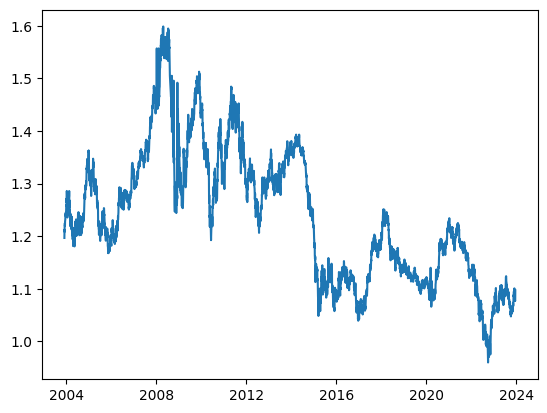

In [ ]:
plt.plot(data.Close)

1/1 [==============================] - 0s 19ms/step


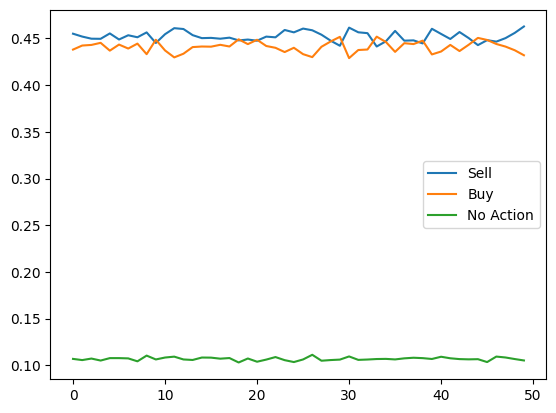

In [ ]:
check = [model_down.predict(((pd.DataFrame(np.repeat(0,91)).T -np.random.normal(0,100,size=len(testX.values[0])) )).fillna(0)) for i in range(50)]

sell_check = []
buy_check = []
no_action_check = []
sell_check.append([i[0][0] for i in check])
buy_check.append([i[0][1] for i in check])
no_action_check.append([i[0][2] for i in check])

import matplotlib.pyplot as plt
plt.plot(sell_check[0])
plt.plot(buy_check[0])
plt.plot(no_action_check[0])
plt.legend(['Sell','Buy','No Action'])

In [ ]:
from google.colab import files
#model_down.save('/content/model_down_HKDEUR.h5')
# Download the saved model file
#files.download('/content/model_down_HKDEUR.h5')

### Fine Tune (don't run this for the time being. Need to resovle)

In [ ]:
loaded_model_down = tf.keras.models.load_model('/content/model_down_HKDEUR.h5')
fine_tune(loaded_model_down, last_update = '2023-09-19', end_date=dt.datetime.today(), stock = stock, m = 6) #Update the date

[*********************100%%**********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/ta/trend.py:780: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
/usr/local/lib/python3.10/dist-packages/ta/trend.py:785: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)


4785
Training Started
Training Finished
[[0. 1. 0.]]
                Open      High       Low     Close  Volume  volume_adi  \
Date                                                                     
2023-09-19  1.375484  1.362107  1.393114  1.380662     0.0         0.0   

            volume_obv  volume_cmf  volume_fi  volume_em  ...  momentum_ppo  \
Date                                                      ...                 
2023-09-19         0.0         0.0        0.0        0.0  ...      0.879595   

            momentum_ppo_signal  momentum_ppo_hist  momentum_pvo  \
Date                                                               
2023-09-19             0.799931           0.422717           0.0   

            momentum_pvo_signal  momentum_pvo_hist  momentum_kama  others_dr  \
Date                                                                           
2023-09-19                  0.0                0.0       1.301667  -0.229563   

            others_dlr  others_cr  
Date

In [ ]:
from google.colab import files
loaded_model_down.save('/content/model_down_HKDEUR_ft.h5')
# Download the saved model file
files.download('/content/model_down_HKDEUR_ft.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

###Prediction

In [ ]:
loaded_model_down = tf.keras.models.load_model('/content/model_down_HKDEUR.h5')

In [ ]:
# loaded_model_down_ft = tf.keras.models.load_model('/content/model_down_HKDEUR_ft.h5')

In [ ]:
# CNN Model prediction
# y_pred_up =  model_up.predict(testX).argmax(axis=1)[0]
# y_pred_down =  model_down.predict(testX).argmax(axis=1)[0]
# self.evt.consoleLog('y_pred_u :', y_pred_up)
# self.evt.consoleLog('y_pred_d :', y_pred_down)
print(str(ta_df.index[-1]).split(' ')[0]+ ' Close Price of '+stock+ " "+str(data['Close'][-1]))
# if ( time in up):
if up:
    print('model up used')
    # y_pred_up =  model_up.predict(testX).argmax(axis=1)[0] #Original
    y_pred_up =  model_up.predict(((testX -mean ) / sd).fillna(0)).argmax(axis=1)[0] #Modify
    # print(model_up.predict(((testX -mean ) / sd).fillna(0)))

    if  int(y_pred_up)  == 0 : # Sell
        print('Sell')
        # self.sample1( buysell = -1, volume = 0.1)
    if  int(y_pred_up) == 1 : # Buy
        print('Buy')
        # self.sample1( buysell = 1, volume = 0.1)
    if  int(y_pred_up) == 2 : # No Action
        print('No Action')

else:
    print('model down used')
    # y_pred_down =  model_down.predict(testX).argmax(axis=1)[0] #Original
    y_pred_down =  loaded_model_down.predict(((testX -mean ) / sd).fillna(0)).argmax(axis=1)[0] #Modify
    print(np.round(loaded_model_down.predict(((testX -mean ) / sd).fillna(0)),2))
    if  int(y_pred_down)  == 0 : # Sell
        print('Sell')
        # self.sample1( buysell = -1, volume = 0.1)
    if  int(y_pred_down) == 1 : # Buy
        print('Buy')
        # self.sample1( buysell = 1, volume = 0.1)
    if  int(y_pred_down) == 2 : # No Action
        print('No Action')

2023-10-04 Close Price of HKDEUR=X 0.12168999761343002
model down used
1/1 [==============================] - 0s 21ms/step
[[0.26 0.24 0.5 ]]
No Action


In [ ]:
yf.download(stock)

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2005-04-06,0.099700,0.099700,0.099450,0.099630,0.099630,0
2005-04-07,0.099630,0.099830,0.099100,0.099800,0.099800,0
2005-04-08,0.099770,0.100050,0.099110,0.099110,0.099110,0
2005-04-11,0.099240,0.099310,0.098630,0.098860,0.098860,0
2005-04-12,0.098840,0.099630,0.098610,0.099280,0.099280,0
...,...,...,...,...,...,...
2023-09-26,0.120783,0.120995,0.120498,0.120781,0.120781,0
2023-09-27,0.120960,0.121666,0.120919,0.120962,0.120962,0
2023-09-28,0.121689,0.121765,0.120741,0.121696,0.121696,0
